## **Social Network for transaction data**
Reference: [Feature Weighting in Content Based RecommendationSystem Using Social Network Analysis](https://www.researchgate.net/publication/221022528_Feature_weighting_in_content_based_recommendation_system_using_social_network_analysis), [website](http://www.ra.ethz.ch/cdstore/www2008/www2008.org/papers/xhtml/pp049/www2008-sample/index.html)


### **Import necessary libraries**

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline

### **Import item dataset**
- Item Data: final_annotated_item_dataset.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#change directory to current location
%cd /content/drive/My Drive/DMC

Mounted at /content/drive
/content/drive/My Drive/DMC


In [ ]:
#Load books data
#books_data = pd.read_csv('final_annotated_item_dataset.csv')
books_data = pd.read_csv('publisher_author_cluster_added_new.csv')
books_data.drop(['Unnamed: 0'], axis= 1, inplace=True)
print(books_data.shape)
books_data.head()

(78030, 11)


,itemID,title,author,publisher,main topic,subtopics,language,description,ISBN_13,interest_age,LangDetect
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],en,A brand-new story in the best-selling Princess...,"[{'type': 'ISBN_13', 'identifier': '9781409048...",1,en
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",de,NaN,"[{'type': 'ISBN_10', 'identifier': '3849927601...",1,de
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",en,The first novel in the #1 bestselling RED QUEE...,"[{'type': 'ISBN_13', 'identifier': '9781409150...",1.5,en
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",de,Ein wunderschönes Freundebuch zur Erinnerung a...,"[{'type': 'ISBN_13', 'identifier': '9798691079...",0,de
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]",de,NaN,"[{'type': 'ISBN_13', 'identifier': '9798691079...",0,de


# **Build the Social Network (use transaction data)**
- Transaction data: preprocessed_transactions.csv

In [ ]:
#Load transaction data
transactions_data = pd.read_csv('preprocessed_transactions.csv')
transactions_data.drop(['Unnamed: 0'], axis= 1, inplace=True)
print(transactions_data.shape)
transactions_data.head()

(365143, 5)


,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0


In [ ]:
network = transactions_data.copy()

#dictionary net will record sessionID (unique) and itemID
net = {}

def build_network(sessionID, itemID):
  if sessionID in net:
    net[sessionID].append(itemID)
  else:
    net[sessionID] = [itemID] 
  return(0)

for index, i in network.iterrows():
  build_network(i['sessionID'], i['itemID'])

In [ ]:
!pip install networkx

**Create social network (undirected weighted graph):**
- Each **vertex** represents an itemID
- Each **edge** represents the relationship between two itemID:
  - if itemID i & j appears in a same sessionID, then there will be a edge between i and j
- Each edge has a **weight**:
  - the value of weight is equal the frequency that item i & j happens in the same sessionID (no matter their action is a click, basket, or oder). If they happen at the same time in a sessionID, we will increase 1 on weight. For example, if item i and j appears simultaneously in both session a and session b, then the edge weight of item i and j will be 2.

In [ ]:
from itertools import combinations 
from collections import Counter

def add_link(nodes):
  result = dict(Counter(combinations(nodes, 2)))
  #print(result)

  for key,value in result.items():
    if (key[0], key[1]) in G.edges():
      G.edges[key[0], key[1]]['weight'] += 1
    else:
      G.add_edge(key[0], key[1], key='edge', weight=1)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

#G is a social network
G = nx.Graph()

for key,value in net.items():
  if(len(value) > 1):
    add_link(value)
    #print(key, value)

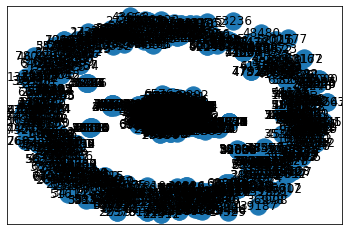

In [ ]:
#nx.draw_networkx(G)

In [ ]:
print(nx.info(G)) #nodes means itemID #edges means item i and item j appear in the same sessionID at the same time 

Name: 
Type: Graph
Number of nodes: 14279
Number of edges: 303666
Average degree:  42.5332


In [ ]:
# List all the shortest path length between nodes while considering the weight
#shortest1 = nx.shortest_path_length(G, weight="weight")
# Calculate eccentricity, which is the maximum distance from v to all other nodes in network
#ecc = nx.eccentricity(G, sp=dict(shortest1))
# And then use diameter to consider the maximum distance among all nodes in network
#nx.diameter(G, e=ecc)

In [ ]:
#connected components
print("Number of connected components: ", nx.number_connected_components(G))

Number of connected components:  325


In [ ]:
#list(G.nodes)

**Save the social network into csv file**

In [ ]:
###save the traction network into a csv file
###this csv will be used as a dataframe later
#with open('transaction_network.csv', 'w') as f:
  #f.write('itemID_i' + '\t' + 'itemID_j' + '\t' + 'weight' + '\n')
  #for (item_i, item_j, w) in G.edges(data=True):
    #f.write(str(item_i) + '\t' + str(item_j) + '\t' + str(w['weight']) + '\n')

# **Load transaction_network data**
- social network data: transaction_network.csv

In [ ]:
transaction_network = pd.read_csv('transaction_network.csv', delimiter='\t')
print('number of network edge: ', len(transaction_network))
transaction_network.head()
#weight value will be y in a regression model

number of network edge:  303666


,itemID_i,itemID_j,weight
0,14576,17731,6
1,14576,4753,1
2,14576,50523,2
3,14576,6540,1
4,14576,72731,1


# **Data Preprocessing**
- Deal with the 'None' item on Interest_age: if data is 'None', then change it to a value 20 (same as the others type)

In [ ]:
df = books_data.copy()
len(df)

78030

In [ ]:
#df['interest_age'].value_counts()

In [ ]:
#if interest_age = 'None', we assigned the item value 20 (as one of the member in Group others)
df['interest_age'] = [20 if i == 'None' else i for i in df['interest_age']]

#change data type from string to float
df['interest_age'] = df['interest_age'].astype(float)
#type(df.iloc[0]['interest_age'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78030 entries, 0 to 78029
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   itemID        78030 non-null  int64  
 1   title         78030 non-null  object 
 2   author        74790 non-null  object 
 3   publisher     78021 non-null  object 
 4   main topic    77772 non-null  object 
 5   subtopics     78029 non-null  object 
 6   language      78030 non-null  object 
 7   description   62378 non-null  object 
 8   ISBN_13       77112 non-null  object 
 9   interest_age  78030 non-null  float64
 10  LangDetect    78030 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 6.5+ MB


**Function for Text Preprocessing**

In [ ]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text, item_lang):
    if item_lang in lang_in_nltk:
        text = text.split()
        stops = set(stopwords.words(item_lang)) #change to other language #"english"
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

**Function for bm25 calculation**

In [ ]:
!pip install rank-bm25
from rank_bm25 import BM25Okapi

def calculate_bm25(query, corpus):
    tokenized_corpus = [doc.split(" ") for doc in corpus]
    bm25 = BM25Okapi(tokenized_corpus)
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    return doc_scores

**Function for Linsimilarity**

In [ ]:
#The Linsimilarityfunction gets two strings (two main topics), Based on Lin similarity formula, then a floating number will
#return as a measure for similarity of two books.
import math

def linsimilarityfunction (maintopic1 , maintopic2):
    #if two topics are identical the Lin similarity measure should be 1:
    if (maintopic1 == maintopic2):
        return 1
    #if they are not identical, we should do further analysis.
    #we compare the first elements of both lists. If they differ from each other, the Lin similarity will be zero.
    elif (maintopic1[0] != maintopic2[0]):
        return 0
    #otherwise we need further steps!
    else:
        #here we simply find the frequency of each topic in our dataset as it is required by Lin similarity
        totalitems = df['main topic'].count()
        minlength=min(len(maintopic1),len(maintopic2))
        df1=df[df['main topic']==maintopic1]
        df2=df[df['main topic']==maintopic2]
        count1=df1['main topic'].count()
        count2=df2['main topic'].count()
        #Now, we can focus on finding the closest mutual ancestor of both topics. By close, we refer to number of
        #node traverse in the tree of all topics.
        i=minlength
        while (i>0):
            if (maintopic1[:i]==maintopic2[:i]):
                dfmutual=df[df['main topic'].str[:i]==maintopic1[:i]]
                countmutual=dfmutual['main topic'].count()
                sim = 2*math.log10(countmutual/totalitems)/(math.log10(count1/totalitems)+math.log10(count2/totalitems))
                return sim
            else:
                i=i-1

In [ ]:
linsimilarityfunction ('YB', 'YFB' )

0.10116165919446315

## **Add new column for each edge relation (lang, title, author, interest age, topic, description)**
*   we have to calculate the difference of item_i and item_j in the below features

**Normalization for each feature:**
1. **Language:** either 1 (same language) or 0 (different language)
2. **Author:** either 1 (same author) or 0 (different author)
3. **Title:** take all items which are in social network as candidate corpus, then take item i as query title and calculate the bm25 for item j's title. **(did not normalize the bm25 score yet)**
4. **Main topic:** linsimilarity range from 0 to 1, so does not need other normalization
5. **interest age:** ((interest_age of item_i - interest_age of item_j) - 0) / (20 - 0) (Use min-max normalization)

In [ ]:
trans_network = transaction_network.copy()
print(trans_network.head())

In [ ]:
#trans_network['lang'] = 'null'
#print(trans_network.head())

   itemID_i  itemID_j  weight  lang
0     14576     17731       6  null
1     14576      4753       1  null
2     14576     50523       2  null
3     14576      6540       1  null
4     14576     72731       1  null


**Prepare title corpus based on the social network for bm25 calculation**
- not all items (78030) in original item.csv is an candidate in this corpus
- only 14279 items is included

In [ ]:
#title corpus for dataframe trans_network (only take items which are nodes in the transaction network)
find_node = df.copy()
nodes = list(G.nodes)

title_corpus = find_node[find_node.itemID.isin(nodes)].reset_index()
print(len(title_corpus))
print(title_corpus.head())

14279
   index  itemID  ... interest_age LangDetect
0      1   73018  ...          1.0         de
1      2   19194  ...          1.5         en
2      3   40250  ...          0.0         de
3      4   46107  ...          0.0         de
4      5   34217  ...         20.0         de

[5 rows x 12 columns]


In [ ]:
%%time

def calculate_difference(item_i, item_j, index):

  #Find item i&j s' index in dataframe df (item data)
  item_i_index = int(df[df['itemID'] == item_i].index.values)
  item_j_index = int(df[df['itemID'] == item_j].index.values)

  #1. Language: whether item i&j in same language (yes: 1 or no: 0)
  lang_i = df.iloc[item_i_index]['language']
  #print(lang_i)
  lang_j = df.iloc[item_j_index]['language']
  #print(lang_j)
  if (lang_i == lang_j): 
    trans_network.loc[index,'language'] = 1
  else:
    trans_network.loc[index,'language'] = 0


  #2. Author: whether item i&j in same author (yes: 1 or no: 0)
  author_i = df.iloc[item_i_index]['author']
  author_j = df.iloc[item_j_index]['author']
  if (author_i == author_j): 
    trans_network.loc[index,'author'] = 1
  else:
    trans_network.loc[index,'author'] = 0

  #3. Title: BM25 scores
  title_i = df.iloc[item_i_index]['title']
  title_j = df.iloc[item_j_index]['title']

  tokenized_corpus = [doc.split(" ") for doc in title_corpus.title]
  bm25 = BM25Okapi(tokenized_corpus)
  tokenized_query = title_i.split(" ")
  doc_scores = bm25.get_scores(title_i)
  #print(doc_scores)

  item_j_location = int(title_corpus[title_corpus['itemID'] == item_j].index.values)
  trans_network.loc[index,'title'] = doc_scores[item_j_location]

  #4. Main Topic: use linsimilarity
  topic_i = df.iloc[item_i_index]['main topic']
  topic_j = df.iloc[item_j_index]['main topic']

  #print(index)
  if type(topic_i) == str and type(topic_j) == str:
    trans_network.loc[index,'main_topic'] = linsimilarityfunction (topic_i, topic_j)

  #5. Interest Age
  age_i = df.iloc[item_i_index]['interest_age']
  age_j = df.iloc[item_j_index]['interest_age']
  trans_network.loc[index,'interest_age'] = (age_i - age_j) / 20

#read each row
for index, i in trans_network.iterrows():
  if (index%1000 == 0): print(index)
  calculate_title_diff(i['itemID_i'], i['itemID_j'], index)

#save the result as a csv file
#trans_network.to_csv('transaction_network_data_all.csv', index=False)

#calculate_title_diff(14576, 17731, 0)
print(trans_network.head())

   itemID_i  itemID_j  weight  language  author  main_topic  interest_age
0     14576     17731       6       1.0     1.0    0.175094         0.000
1     14576      4753       1       1.0     0.0    0.000000        -0.925
2     14576     50523       2       1.0     0.0    0.000000        -0.925
3     14576      6540       1       0.0     0.0    0.000000        -0.025
4     14576     72731       1       0.0     0.0    0.000000        -0.925


## **Read network data**

In [ ]:
trans_network = pd.read_csv('transaction_network_data_all.csv')
trans_network = trans_network.drop(columns=['index'])
trans_network.head()

,itemID_i,itemID_j,weight,language,author,main_topic,interest_age,title
0,14576,17731,6,1.0,1.0,0.175094,0.000,1.335705
1,14576,4753,1,1.0,0.0,0.000000,-0.925,0.000000
2,14576,50523,2,1.0,0.0,0.000000,-0.925,0.000000
3,14576,6540,1,0.0,0.0,0.000000,-0.025,0.000000
4,14576,72731,1,0.0,0.0,0.000000,-0.925,0.000000
